In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.ao.nn.quantized.functional import threshold
from torch.utils.data import DataLoader

from models import Autoencoder
from utils import train_autoencoder, load_mnist

from utils import knn_impute_image, mean_impute_image
from utils import Missingness

In [2]:
train_data, test_data = load_mnist()

train_loader = DataLoader(train_data, batch_size=256, shuffle=True)
test_loader = DataLoader(test_data, batch_size=256, shuffle=True)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ae = Autoencoder()

optimizer = torch.optim.Adam(ae.parameters(), lr=1e-3)
loss_fn = torch.nn.MSELoss()
ae.load_state_dict(torch.load('../checkpoints/autoencoder_mnist.pth', map_location=device))

<All keys matched successfully>

In [4]:
# losses = train_autoencoder(
#     ae,
#     train_loader,
#     optimizer,
#     loss_fn,
#     epochs=100,
#     device=device
# )

In [5]:
# torch.save(ae.state_dict(), "../checkpoints/autoencoder_mnist.pth")

In [6]:
missingness = Missingness()

In [46]:
def plot_missingness(train_data, missingness, n_cols=4):
    types = [
        lambda img: missingness.mcar(img, missing_rate=0.25)[0],
        lambda img: missingness.mar(img, alpha=5)[0],
        lambda img: missingness.mnar(img, threshold=0.90, inverse=True)[0],
        lambda img: missingness.block_missing(img, size=8)[0],
        lambda img: missingness.row_missing(img, num_rows=5)[0],
        lambda img: missingness.col_missing(img, num_cols=5)[0],
    ]

    n_rows = len(types)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))

    cmap = plt.cm.gray.copy()
    cmap.set_bad(color='red')

    for i in range(n_cols):
        idx = torch.randint(len(train_data), size=(1,)).item()
        img, _ = train_data[idx]

        for row, missing in enumerate(types):
            axs[row][i].imshow(missing(img).squeeze(), cmap=cmap)
            axs[row][i].axis("off")

    fig.tight_layout()
    plt.show()

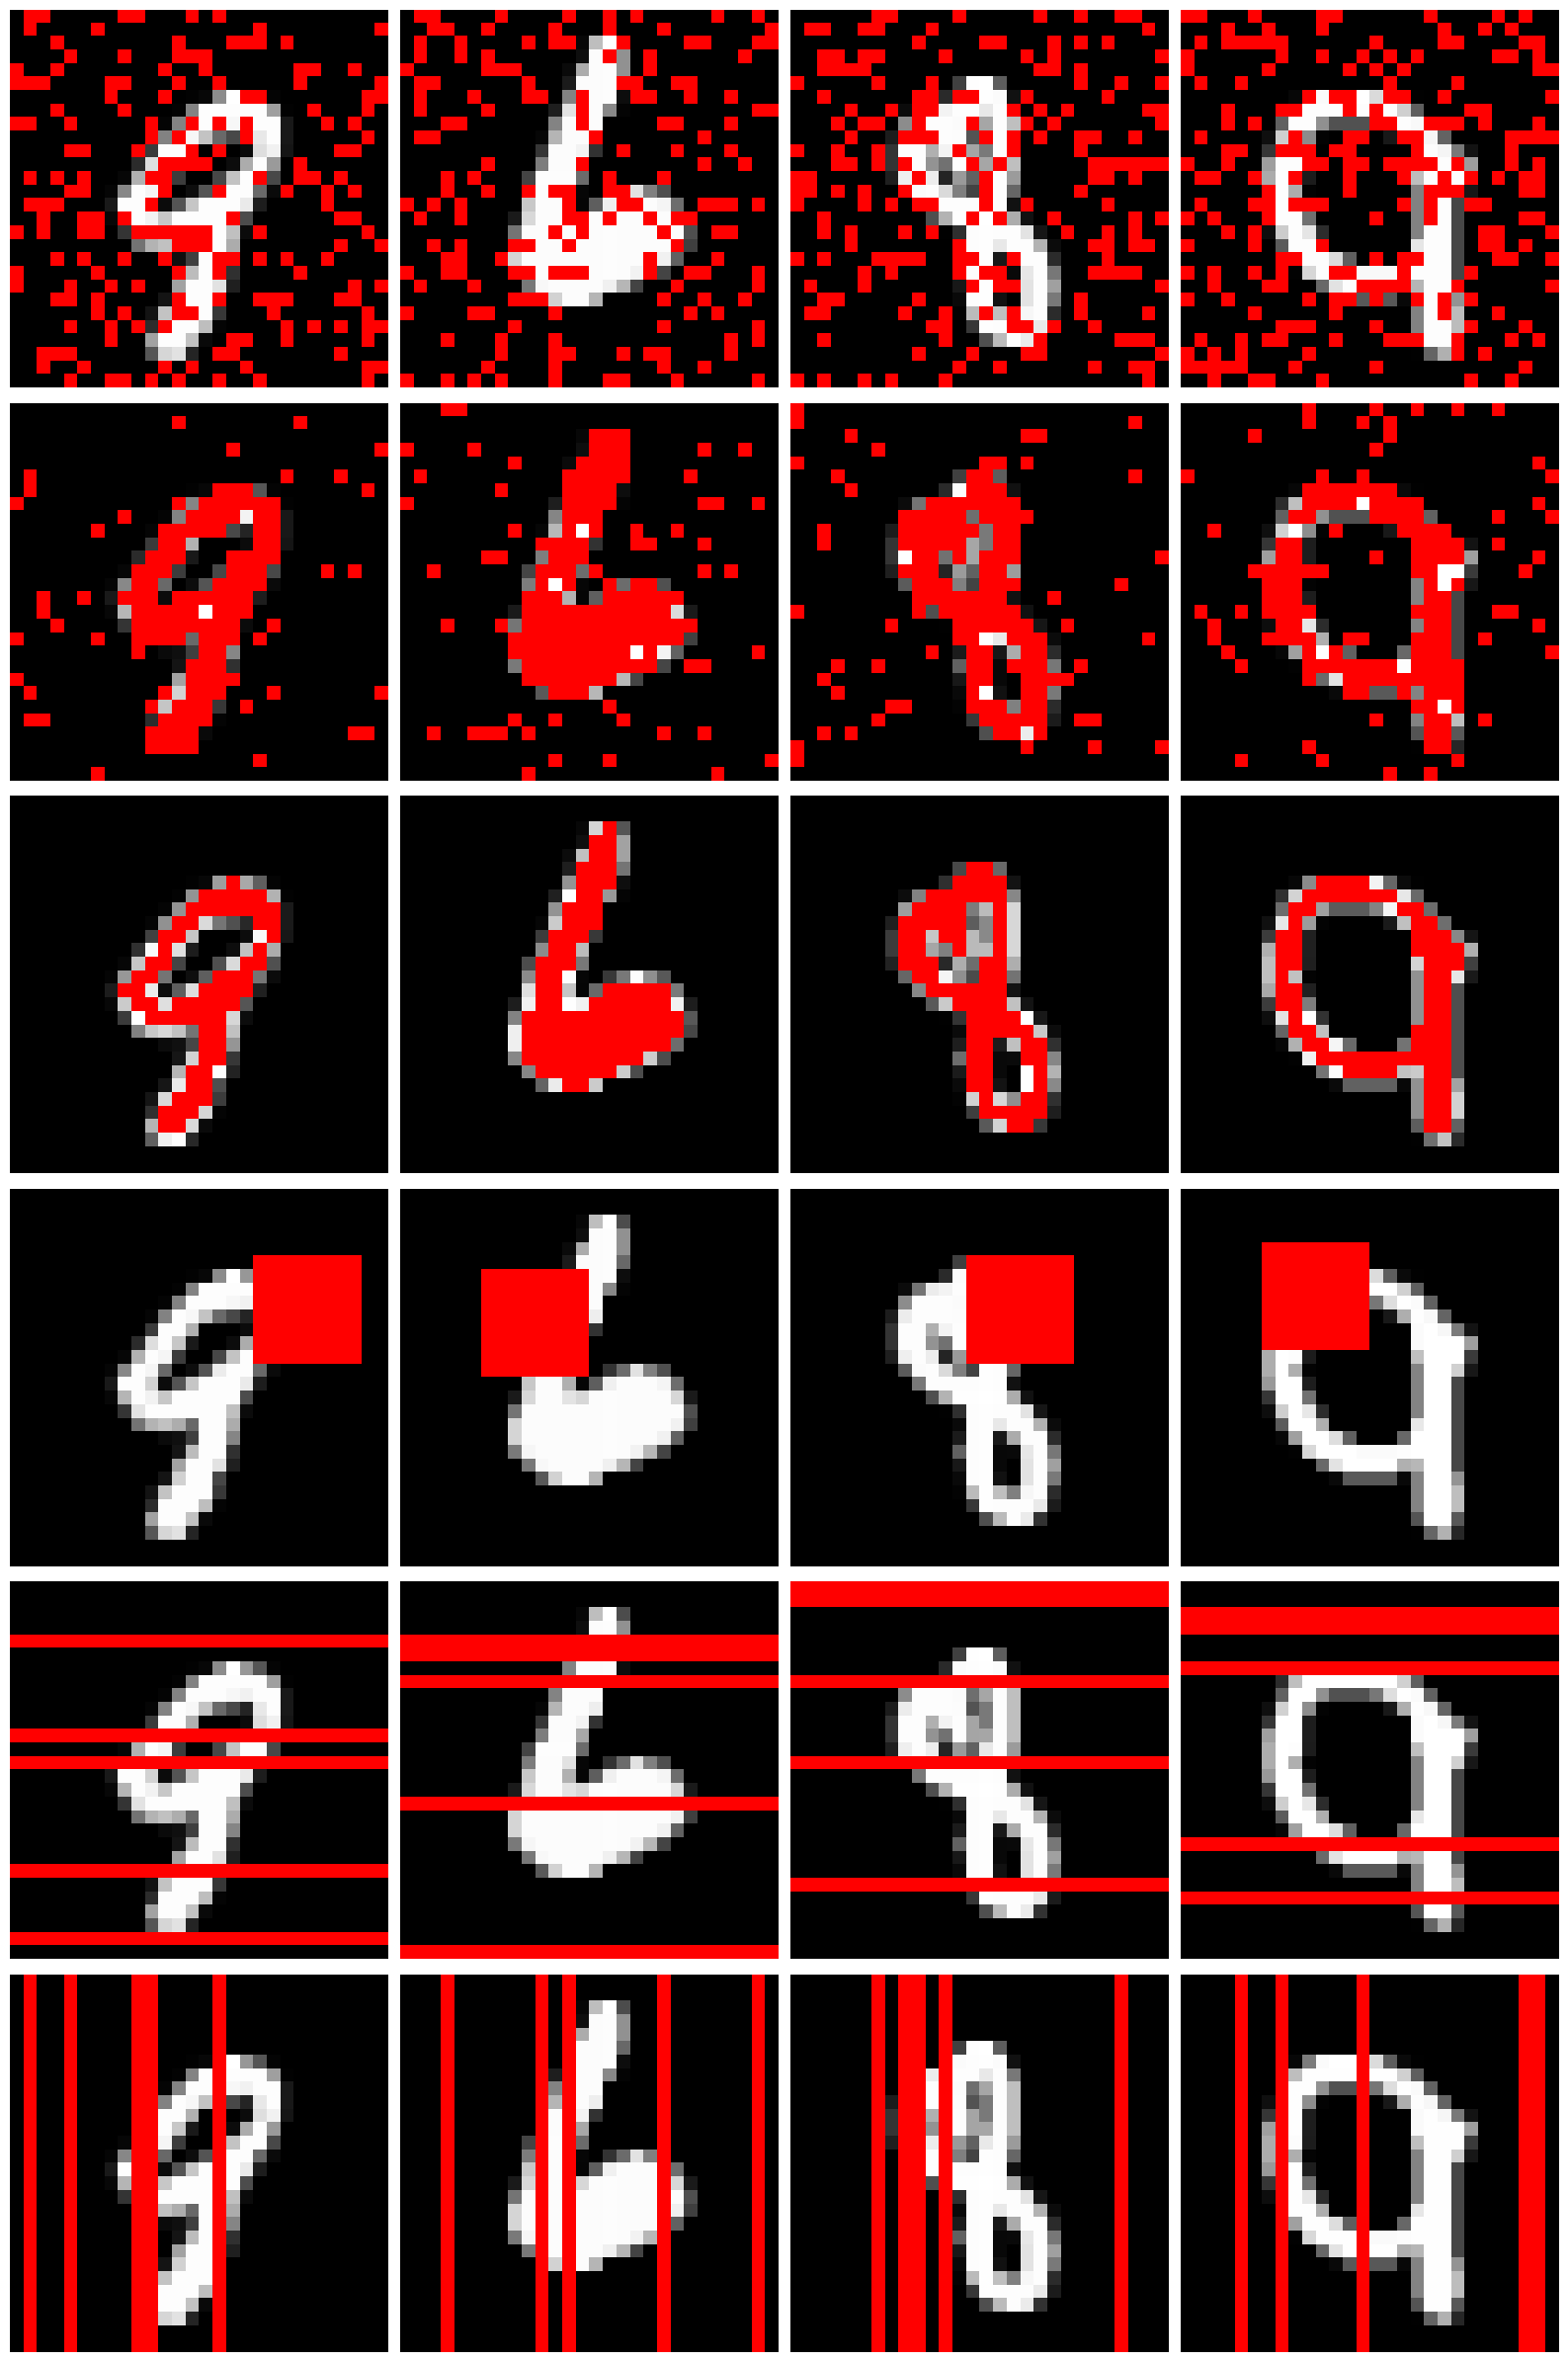

In [47]:
plot_missingness(train_data, missingness)

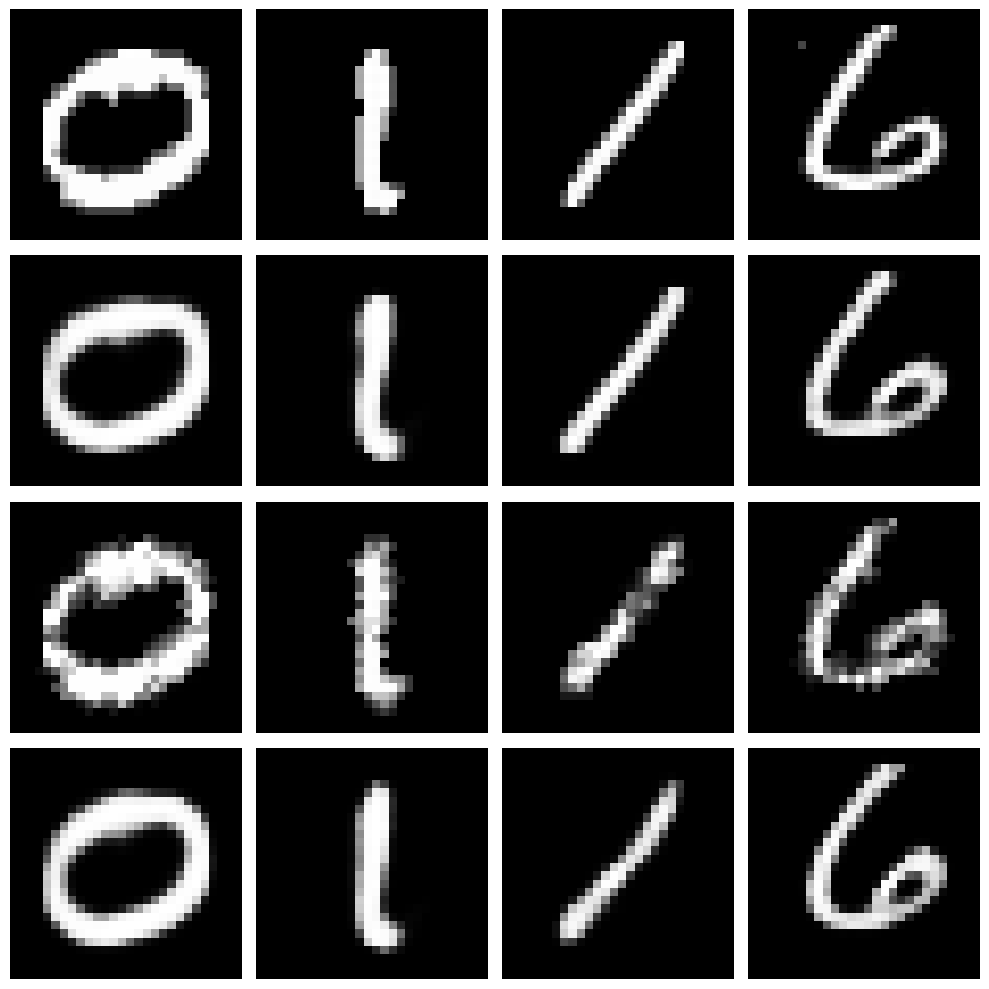

In [8]:
idx = torch.randint(len(train_data), size=(4, 1)).numpy()
ae.eval()

fig, axs = plt.subplots(4, 4, figsize=(10, 10))

for i, index in enumerate(idx):
    img, label = train_data[index.item()]

    masked_img, mask = missingness.mcar(img, missing_rate=0.50)
    # imputed_img = mean_impute_image(masked_img)
    imputed_img = knn_impute_image(masked_img)

    img = img.squeeze()

    reconstructed_img, latent = ae(img.view(784).to(device))
    reconstructed_corrupted, corrupted_latent = ae(imputed_img.view(784).to(device))

    axs[0][i].imshow(img, cmap="gray")
    axs[0][i].axis('off')

    axs[1][i].imshow(reconstructed_img.detach().cpu().view(28, 28), cmap="gray")
    axs[1][i].axis('off')

    axs[2][i].imshow(imputed_img.squeeze(), cmap="gray")
    axs[2][i].axis('off')

    axs[3][i].imshow(reconstructed_corrupted.detach().cpu().view(28, 28), cmap="gray")
    axs[3][i].axis('off')

fig.tight_layout()
plt.show()